# AGC + calver coffea on coffea-casa

We'll base this on a few sources:
- https://github.com/iris-hep/analysis-grand-challenge/tree/main/analyses/cms-open-data-ttbar (AGC, of course)
- https://github.com/alexander-held/CompHEP-2023-AGC (contains a simplified version of AGC)
- https://github.com/nsmith-/TTGamma_LongExercise/ (credit Nick Smith for helpful examples of the new API)
- (and if time allows, weight features: https://github.com/CoffeaTeam/coffea/blob/backports-v0.7.x/binder/accumulators.ipynb / https://coffeateam.github.io/coffea/api/coffea.analysis_tools.Weights.html#coffea.analysis_tools.Weights.partial_weight)

In [1]:
import awkward as ak
import dask
import dask_awkward as dak
import hist.dask
import coffea
import matplotlib.pyplot as plt
import numpy as np
import uproot
from dask.diagnostics import ProgressBar
from dask.distributed import Client, progress

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import PackedSelection
from coffea import dataset_tools

import warnings

import utils
utils.plotting.set_style()

warnings.filterwarnings("ignore")
NanoAODSchema.warn_missing_crossrefs = False # silences warnings about branches we will not use here


client = Client("tls://localhost:8786")

print(f"awkward: {ak.__version__}")
print(f"dask-awkward: {dak.__version__}")
print(f"uproot: {uproot.__version__}")
print(f"hist: {hist.__version__}")
print(f"coffea: {coffea.__version__}")

/usr/local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


awkward: 2.6.1
dask-awkward: 2024.2.0
uproot: 5.2.2
hist: 2.7.2
coffea: 2024.2.1


### Produce an AGC histogram with Dask (no coffea yet)

In [2]:
def calculate_trijet_mass(events):
    # pT > 30 GeV for leptons, > 25 GeV for jets
    selected_electrons = events.Electron[events.Electron.pt > 30 & (np.abs(events.Electron.eta) < 2.1)]
    selected_muons = events.Muon[events.Muon.pt > 30 & (np.abs(events.Muon.eta) < 2.1)]
    selected_jets = events.Jet[events.Jet.pt > 25 & (np.abs(events.Jet.eta) < 2.4)]

    # single lepton requirement
    event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
    # at least four jets
    event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
    # at least two b-tagged jets ("tag" means score above threshold)
    B_TAG_THRESHOLD = 0.5
    event_filters = event_filters & (ak.sum(selected_jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2)

    # apply filters
    selected_jets = selected_jets[event_filters]

    trijet = ak.combinations(selected_jets, 3, fields=["j1", "j2", "j3"])  # trijet candidate
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # four-momentum of tri-jet system

    trijet["max_btag"] = np.maximum(trijet.j1.btagCSVV2, np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2))
    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in trijet candidates
    # pick trijet candidate with largest pT and calculate mass of system
    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
    return ak.flatten(trijet_mass)

In [3]:
ttbar_file = "https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/"\
    "TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19981_PU25nsData2015v1_76X_"\
    "mcRun2_asymptotic_v12_ext4-v1_80000_0007.root"


events = NanoEventsFactory.from_root({ttbar_file: "Events"}, schemaclass=NanoAODSchema).events()

# create the task graph to build a histogram
reconstructed_top_mass = calculate_trijet_mass(events)
hist_reco_mtop = hist.dask.Hist.new.Reg(16, 0, 375, label="$m_{bjj}$").Double().fill(reconstructed_top_mass)

# low-level vs high-level graph: https://iris-hep.slack.com/archives/CFZ4Z2Q2H/p1701114439847169
# reconstructed_top_mass.dask  # "high-level graph"
# reconstructed_top_mass.visualize(optimize_graph=False)  # "low-level graph"

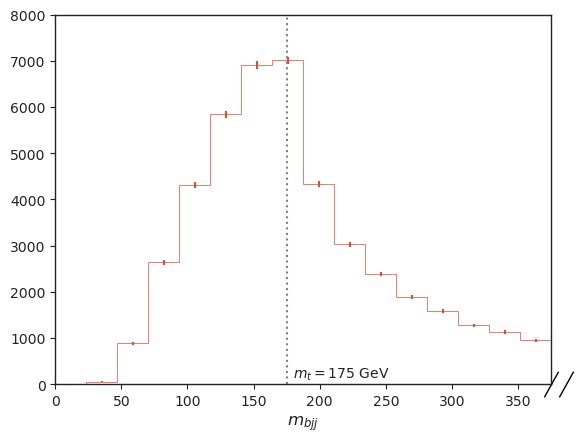

In [4]:
# perform computation and visualize
hist_reco_mtop.compute().plot()
plt.vlines(175, 0, 10000, colors=["grey"], linestyle="dotted")
plt.text(180, 150, "$m_{t} = 175$ GeV")
plt.xlim([0, 375])
plt.ylim([0, 8000]);

This all matches the (non-Dask) versions of the plots from last summer — see the notebook linked above. Not surprising, but reassuring!

### Time for coffea

In [5]:
# function encoding the observable calculation
def calculate_m_reco_top(events):
    process = events.metadata["process"]  # "ttbar" etc.
    variation = events.metadata["variation"]  # "nominal" etc.

    # normalization for MC
    x_sec = events.metadata["xsec"]
    nevts_total = events.metadata["nevts"]
    lumi = 3378 # /pb
    if process != "data":
        xsec_weight = x_sec * lumi / nevts_total
    else:
        xsec_weight = 1

    elecs = events.Electron
    muons = events.Muon
    jets = events.Jet

    electron_reqs = (elecs.pt > 30) & (np.abs(elecs.eta) < 2.1) & (elecs.cutBased == 4) & (elecs.sip3d < 4)
    muon_reqs = ((muons.pt > 30) & (np.abs(muons.eta) < 2.1) & (muons.tightId) & (muons.sip3d < 4) &
                 (muons.pfRelIso04_all < 0.15))
    jet_reqs = (jets.pt > 30) & (np.abs(jets.eta) < 2.4) & (jets.isTightLeptonVeto)

    # Only keep objects that pass our requirements
    elecs = elecs[electron_reqs]
    muons = muons[muon_reqs]
    jets = jets[jet_reqs]

    B_TAG_THRESHOLD = 0.5

    ######### Store boolean masks with PackedSelection ##########
    selections = PackedSelection(dtype='uint64')
    # Basic selection criteria
    selections.add("exactly_1l", (ak.num(elecs) + ak.num(muons)) == 1)
    selections.add("atleast_4j", ak.num(jets) >= 4)
    selections.add("atleast_2b", ak.sum(jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2)
    # Complex selection criteria
    selections.add("4j2b", selections.all("exactly_1l", "atleast_4j", "atleast_2b"))

    # only perform 4j2b selection here
    region_selection = selections.all("4j2b")
    region_jets = jets[region_selection]

    # reconstruct hadronic top as bjj system with largest pT
    trijet = ak.combinations(region_jets, 3, fields=["j1", "j2", "j3"])  # trijet candidates
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # four-momentum of tri-jet system
    trijet["max_btag"] = np.maximum(trijet.j1.btagCSVV2,
                                    np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2))
    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in candidates
    # pick trijet candidate with largest pT and calculate mass of system
    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
    observable = ak.flatten(trijet_mass)

    return observable, dak.ones_like(observable) * xsec_weight


# create histograms with observables
def create_m_reco_top_histograms(events):
    hist_m_reco_top = (
        hist.dask.Hist.new.Reg(25, 50, 550, name="m_reco_top", label=r"$m_{bjj}$ [GeV]")
        .StrCat([], name="process", label="Process", growth=True)
        .StrCat([], name="variation", label="Systematic variation", growth=True)
        .Weight()
    )

    observable, weight = calculate_m_reco_top(events)
    hist_m_reco_top.fill(observable, weight=weight, process=events.metadata["process"], variation = events.metadata["variation"])
    return hist_m_reco_top

In [6]:
# fileset preparation
N_FILES_MAX_PER_SAMPLE = 1
fileset = utils.file_input.construct_fileset(N_FILES_MAX_PER_SAMPLE)  # compared to coffea 0.7: list of file paths becomes list of dicts (path: trename)

# fileset = {"ttbar__nominal": fileset["ttbar__nominal"]}
# fileset

In [7]:
%%time
# pre-process
samples, _ = dataset_tools.preprocess(fileset, step_size=250_000)

# workaround for https://github.com/CoffeaTeam/coffea/issues/1050 (metadata gets dropped)
for k, v in samples.items():
    v["metadata"] = fileset[k]["metadata"]

CPU times: user 89.5 ms, sys: 4.5 ms, total: 94 ms
Wall time: 2.89 s


In [8]:
%%time
# create the task graph
tasks = dataset_tools.apply_to_fileset(create_m_reco_top_histograms, samples, uproot_options={"allow_read_errors_with_report": True})

CPU times: user 6.21 s, sys: 71.5 ms, total: 6.28 s
Wall time: 6.65 s


In [9]:
%%time
# execute
((out,report),) = dask.compute(tasks)  # feels strange that this is a tuple-of-tuple

print(f"total time spent in uproot reading data (or some related metric?): {ak.sum([v['duration'] for v in report.values()]):.2f} s")

total time spent in uproot reading data (or some related metric?): 439.58 s
CPU times: user 1.36 s, sys: 17.4 ms, total: 1.38 s
Wall time: 1min


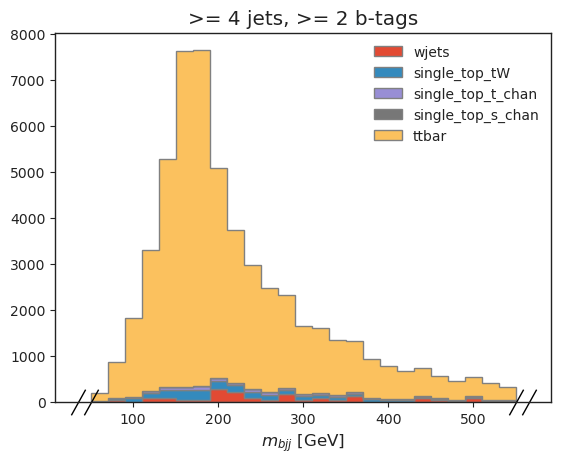

In [10]:
full_histogram = sum(out.values())  # stack all the histograms together (we processed each sample separately)

full_histogram[:, :, "nominal"].stack("process")[::-1].plot(
    stack=True, histtype="fill", linewidth=1,edgecolor="grey"
)
plt.legend(frameon=False)
plt.title(">= 4 jets, >= 2 b-tags");

This is a plot you can compare to the one in the full AGC notebook — you'll notice they look the same. Success!

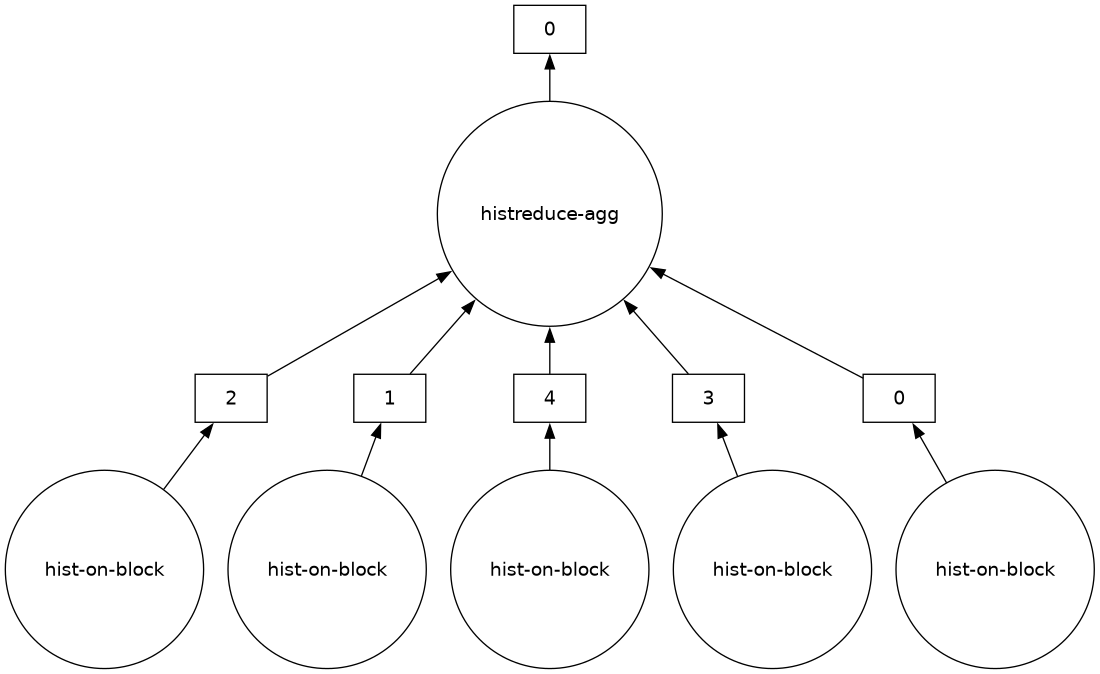

In [11]:
tasks[0]["ttbar__nominal"].visualize(optimize_graph=True)

In [12]:
tasks[0]["ttbar__nominal"].dask  # HighLevelGraph with 96 layers and 476 keys from all layers. -> given "100 layers is a large task graph" on Slack, 100 layers happen quickly! 

HighLevelGraph with 96 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7f7effec50f0>
 0. from-uproot-deb1daa50963f1946803f1b27b62e348
 1. first-a86f88359409825d3a050ae1eed7dafe
 2. Muon-9dae26d48e0801f68353bf09b58cae13
 3. pfRelIso04-all-729e2d2f49aa412316927313637c255a
 4. less-b94d880e8dc0d1890568448fdeead207
 5. sip3d-00d562b2644de2cfc4b6375465b355dd
 6. less-bed62278dff6bc9c481df705316a12c0
 7. tightId-853f111947d3b6e6dcce8e04791f0030
 8. eta-45d9cc52b1a26b2c76e418e7b60d10f1
 9. absolute-108bd1bdb9f5da111400bf021099859b
 10. less-b7488415aa51d2877008dbbbfc44b560
 11. pt-280dc2d81ad4ddc3c61d80e946c36bc1
 12. greater-0de5b22a568592d8902c22a61249f73d
 13. bitwise-and-cfe16055bfc15f44146743f9a3df8548
 14. bitwise-and-62b14eb32e125f7d36766e9bed704091
 15. bitwise-and-b0ef24746180c2c10c812141238886c9
 16. bitwise-and-688df321c2acfcad82753c8cca908892
 17. getitem-9fdfa85bb9bbe7cc00a8169e22714bd7
 18. num-60b0c8014b3b7903e1897a9b5ee9d002
 19. Electron-9fa70a6e89d2d09dd3b45a6fe24e6d8a
 20. sip3d-51c125ad162c8151005e082d1ad6bdab
 21. less-58a26f7b58b7072652f21ccb9d184b05
 22. cutBased-60b3b8164c60935902cc86ac824698fa
 23. equal-48ab9d056552370343a9f0d75f2f3d23
 24. eta-ece6162e57d97d348056f7450883396d
 25. absolute-64cb3756380524962eec32125c0adca4
 26. less-f13e043cae5d4642d094f090c48c7286
 27. pt-c6bf0768908aa46de0b1e148486ec89c
 28. greater-29cad60c578426ef97947f38e9413b9b
 29. bitwise-and-60af25281e1529656c6f6a7063ab39e3
 30. bitwise-and-33552c630bbff7c8e59bd1d8db850a62
 31. bitwise-and-eb85c717764f5325895ac5e219b5fdc7
 32. getitem-1bf853598f49bc36637ff87cdeb1470f
 33. num-ab27842cdea068f0b8181ea1597ab0ab
 34. add-d3eabd53a786b161dbd9374a8aa575cd
 35. equal-d652f8572afdf18634d712421424463a
 36. multiply-0c5c38be591038a30a1c3bbc675bf00b
 37. zeros-like-86f23a66d1153a1f352ccdd225ffc752
 38. bitwise-or-da2150e81c7cbbeeb01fa97978840914
 39. Jet-fe75ddbf59fb1d2cee3d9908b095b844
 40. isTightLeptonVeto-aa7d4fd5bc4b938b521269d68675f7e8
 41. eta-6cc94036c0dc02a568b1c027f1c91cee
 42. absolute-86693f95466f833eb6dc8ecde5412fd5
 43. less-0b540a5d91407247f5fdf4290c251d47
 44. pt-c16197bc1a618a72309e8f2d71e9b8c9
 45. greater-d5697b82d9687305a047f48d1d3ce711
 46. bitwise-and-357507fe0cb0ec7d8f9f55db0a167898
 47. bitwise-and-9793e041d84af6b5b9f7b0b62bfc7a61
 48. getitem-23dbee260220fd01e60ddb595ac69838
 49. btagCSVV2-784abb75a237cf9f608a09ba87d1abf0
 50. greater-29c7bd996331b35bd3cbee297ab9cb0c
 51. sum-e9aa290425c83a24312ef68b07015760
 52. greater-equal-b4fb618dfe7ee450c75995239b7ee8e1
 53. multiply-90e8e280cb788843b971f2fc7e00ea5f
 54. num-b47c87441e619b12aaa94cd804dc15a7
 55. greater-equal-bdb8f7adb5800267464e48fc5b6e3cac
 56. multiply-8f6bb708591cb6255f527c80d58a4a92
 57. bitwise-or-e843cae14b8db664242e905c6cb07b38
 58. bitwise-or-ac6cf47c7f8d755c9b7c8c0be1fa3de2
 59. bitwise-and-6a6091ba0287b0168cccc72622ae6b60
 60. equal-3666fa102978a5feb5360c71b526e9ef
 61. multiply-87a49e3e49d6cc8a0ea46ec557f18ec2
 62. bitwise-or-82fb658a5b6a69a43a4763c56f40b7e3
 63. bitwise-and-6a024a672e792b1dedc3413a84d343cc
 64. equal-f79cd02aecff1e6f2b1b772764717401
 65. getitem-83b5592fa4aeaf4aa00424ffbbe5fe53
 66. combinations-96e16a5d7ad7e753154c1aba6893f53e
 67. j3-79a0109be51d4cfb4579be93143fa9a9
 68. j2-0ec14b7fc7ab154dd4c8ff0a45b874aa
 69. j1-bfa9b16686e0cd1714d7d7e56b46321e
 70. add-5f36962314d934fe2383fa13634c664b
 71. add-fef0d1e3604a9bf9944a7bf36b6f1d36
 72. with-field-2e4dac9bd43d7a08e26167b5c7f860a4
 73. j3-ab2e58b2b5a803cee4041922fa8ff498
 74. btagCSVV2-05c2d97e617abf7ac261cc6bd4c12705
 75. j2-ce17114b9c42e2eb3549ea18bdd5e7a0
 76. btagCSVV2-995c0501027b591156fa0b0b30e11d9b
 77. maximum-370c5dbfd466e5bdd9b9c0352c83335a
 78. j1-52d4b8e84bbe87a2d4a57c37cd857f4d
 79. btagCSVV2-b1c8cbfd9e9eed4f261f8fb24b3f5246
 80. maximum-548a201617e402d4a5ba1b1964311572
 81. with-field-5e99df5b782eeab68a895d3e9666a640
 82. max-btag-f57cc6d8c58d45de308d7bf3214d7647
 83. greater-150e7d09e1088ac3c7ffe4023c1fce45
 84. getitem-2c976bffd92ef7eea8e15daa07d6d8ec
 85. p4-53